## Data cleaning

### Set up

We first import the different libraries that we will be using for this project

In [1]:
import pandas as pd
from datetime import datetime 
from unidecode import unidecode


We import our dataset

In [2]:
data_path="data/fires-all.csv"
try:
    fires=pd.read_csv(data_path)
except Exception as error:
    print(f"Error while importing the excel file: {error}")
fires.head()

,id,superficie,fecha,lat,lng,latlng_explicit,idcomunidad,idprovincia,idmunicipio,municipio,...,causa_supuesta,causa_desc,muertos,heridos,time_ctrl,time_ext,personal,medios,gastos,perdidas
0,1968290001,14.0,1968-01-01,NaN,NaN,0,4,29,0,INDETERMINADO,...,1,40,0,0,0,360,0,0,0,0
1,1968430003,3.0,1968-01-03,NaN,NaN,0,2,43,0,INDETERMINADO,...,1,0,0,0,0,60,0,0,0,0
2,1968290006,2.0,1968-01-06,NaN,NaN,0,4,29,0,INDETERMINADO,...,1,0,0,0,0,120,0,0,0,0
3,1968430016,600.0,1968-01-07,NaN,NaN,0,2,43,0,INDETERMINADO,...,1,20,0,0,0,1440,35,1,0,0
4,1968120007,8.2,1968-01-07,NaN,NaN,0,9,12,0,INDETERMINADO,...,1,20,0,0,0,120,0,0,0,0


We analyze the data and observe the type of data on each column and how many nulls values we have

In [3]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284589 entries, 0 to 284588
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               284589 non-null  int64  
 1   superficie       284589 non-null  float64
 2   fecha            284589 non-null  object 
 3   lat              230154 non-null  float64
 4   lng              230154 non-null  float64
 5   latlng_explicit  284589 non-null  int64  
 6   idcomunidad      284589 non-null  int64  
 7   idprovincia      284589 non-null  int64  
 8   idmunicipio      284589 non-null  int64  
 9   municipio        284576 non-null  object 
 10  causa            284589 non-null  int64  
 11  causa_supuesta   284589 non-null  int64  
 12  causa_desc       284589 non-null  int64  
 13  muertos          284589 non-null  int64  
 14  heridos          284589 non-null  int64  
 15  time_ctrl        284589 non-null  int64  
 16  time_ext         284589 non-null  int6

### Remove unnecesary columns

In [4]:
#drop
try:
    fires.drop(["id","causa","causa_supuesta","causa_desc",
                "muertos","heridos","time_ctrl","time_ext",
                "personal","medios","gastos","perdidas",
                "latlng_explicit"],axis=1, inplace=True)
except Exception as error:
    print(f"ERROR while droping the columns {error}")
fires.head()

,superficie,fecha,lat,lng,idcomunidad,idprovincia,idmunicipio,municipio
0,14.0,1968-01-01,NaN,NaN,4,29,0,INDETERMINADO
1,3.0,1968-01-03,NaN,NaN,2,43,0,INDETERMINADO
2,2.0,1968-01-06,NaN,NaN,4,29,0,INDETERMINADO
3,600.0,1968-01-07,NaN,NaN,2,43,0,INDETERMINADO
4,8.2,1968-01-07,NaN,NaN,9,12,0,INDETERMINADO


### Remove unnecesary rows

In [5]:
#We only want the fires of the comunidad 3 (Galicia)
fires=fires[fires["idcomunidad"]==3]
#We drop null values on lat and lng, beacsue we cannot find where the fire happend,
#  and it is older data from  1968
fires=fires.dropna(subset=["lat","lng"])
#We remove the column idcomunidad as it is no longer need it
fires.drop(["idcomunidad"],axis=1,inplace=True)
#print how many null values are for each column
fires.isna().sum(),
#TODO: from the coordinates lat and lng obtain the blanks municipio

(superficie     0
 fecha          0
 lat            0
 lng            0
 idprovincia    0
 idmunicipio    0
 municipio      5
 dtype: int64,)

In [6]:
fires.head()

,superficie,fecha,lat,lng,idprovincia,idmunicipio,municipio
39703,20.0,1980-09-18,42.428281,-6.914337,32,9,"BARCO DE VALDEORRAS, O"
54407,2.0,1983-01-16,42.542185,-8.449205,36,12,COTOBADE
54410,6.0,1983-01-16,42.102572,-8.415920,36,34,"NEVES, AS"
54415,3.0,1983-01-17,43.629834,-7.367642,27,19,FOZ
54417,40.0,1983-01-18,43.018968,-7.408954,27,11,CASTROVERDE


In [7]:
#We save the data for the time series prediction
data_path="data/fires-time-series.xlsx"
try:
    fires.to_excel(data_path,index=False)
except Exception as error:
    print(f"Error while exporting the data to the excel file: {error}")

Error while exporting the data to the excel file: No module named 'openpyxl'


In [8]:
data_path="data/fires-time-series.xlsx"
try:
    fires_time_series=pd.read_excel(data_path)
except Exception as error:
    print(f"Error while importing the excel file: {error}")
fires.head()

Error while importing the excel file: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.


,superficie,fecha,lat,lng,idprovincia,idmunicipio,municipio
39703,20.0,1980-09-18,42.428281,-6.914337,32,9,"BARCO DE VALDEORRAS, O"
54407,2.0,1983-01-16,42.542185,-8.449205,36,12,COTOBADE
54410,6.0,1983-01-16,42.102572,-8.415920,36,34,"NEVES, AS"
54415,3.0,1983-01-17,43.629834,-7.367642,27,19,FOZ
54417,40.0,1983-01-18,43.018968,-7.408954,27,11,CASTROVERDE


### Añadir el tiempo para la prediccion con variables exogenas

#### Filtramos las fechas que sean mas antiguas del 2005

In [9]:
#Solo tenemos informacion a  partir del 2005 de meteorologia
#convertimos las fechas a tipo datetime (para una mejor compatibilidad)
fires['fecha'] = pd.to_datetime(fires['fecha'], errors='coerce')
#filtrar fechas que empiezen a partir del 2005 hasta el 2018
fires = fires.loc[fires['fecha'] >= '2009-01-01']
fires.head()

,superficie,fecha,lat,lng,idprovincia,idmunicipio,municipio
244077,1.0,2009-01-11,42.314177,-8.198452,32,18,CARBALLEDA DE AVIA
244079,5.0,2009-01-11,41.996375,-7.170321,32,34,"GUDIÑA, A"
244082,2.7,2009-01-11,42.333021,-8.314144,36,13,COVELO
244090,2.0,2009-01-12,41.995624,-7.174073,32,34,"GUDIÑA, A"
244094,11.1,2009-01-12,42.290851,-7.620661,32,43,MACEDA


In [10]:
valores_unicos = fires['idprovincia'].unique()
print(valores_unicos)
for valor in valores_unicos:
    print((fires['idprovincia'] == valor).sum())




[32 36 27 15]
4221
1349
1159
1608


In [11]:
fires[fires['idprovincia']==32].head()

,superficie,fecha,lat,lng,idprovincia,idmunicipio,municipio
244077,1.0,2009-01-11,42.314177,-8.198452,32,18,CARBALLEDA DE AVIA
244079,5.0,2009-01-11,41.996375,-7.170321,32,34,"GUDIÑA, A"
244090,2.0,2009-01-12,41.995624,-7.174073,32,34,"GUDIÑA, A"
244094,11.1,2009-01-12,42.290851,-7.620661,32,43,MACEDA
244227,1.5,2009-02-15,42.005325,-7.009491,32,48,"MEZQUITA, A"


In [12]:
#Juntar por semanas en la provincia de Ourense (id32)
# Convertir 'fecha' a datetime
fires['fecha'] = pd.to_datetime(fires['fecha'])

# Filtrar por la provincia 32
fires = fires[fires['idprovincia'] == 32]

fires.drop(["lat","lng","idmunicipio","municipio","idprovincia"],axis=1,inplace=True)

fires.head()

,superficie,fecha
244077,1.0,2009-01-11
244079,5.0,2009-01-11
244090,2.0,2009-01-12
244094,11.1,2009-01-12
244227,1.5,2009-02-15


In [13]:
# Convertir 'fecha' a formato datetime
fires["fecha"] = pd.to_datetime(fires["fecha"], format="%Y-%m-%d")

# Crear nuevas columnas para el año y la semana
fires['Anno'] = fires['fecha'].dt.year
fires['Semana'] = fires['fecha'].dt.isocalendar().week

fires = fires.groupby(["Anno", "Semana"]).agg({
    'superficie': 'sum',           # Suma de superficie
    'fecha': 'count'               # Cuenta de filas agrupadas (número de incendios)
}).rename(columns={'fecha': 'numero_incendios'}).round(2)

fires= fires.reset_index()
fires.head()

,Anno,Semana,superficie,numero_incendios
0,2009,2,6.00,2
1,2009,3,13.10,2
2,2009,7,1.50,1
3,2009,8,96.85,25
4,2009,9,227.66,64


In [14]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Anno              342 non-null    int32  
 1   Semana            342 non-null    UInt32 
 2   superficie        342 non-null    float64
 3   numero_incendios  342 non-null    int64  
dtypes: UInt32(1), float64(1), int32(1), int64(1)
memory usage: 8.5 KB


In [15]:
def normalize_header(header):
    replacements = {
        'á': 'a', 'é': 'e', 'í': 'i', 'ó': 'o', 'ú': 'u',
        'ü': 'u', 'ñ': 'n', 'Á': 'A', 'É': 'E', 'Í': 'I',
        'Ó': 'O', 'Ú': 'U', 'Ü': 'U', 'Ñ': 'N'
    }
    for spanish_char, english_char in replacements.items():
        header = header.replace(spanish_char, english_char)
    return header

#### Juntamos todos los datos en un unico csv por estacion meteo


In [16]:
#Definimos las estaciones de meteorologia
stations=["C01_A Capela_","C02_Boimorto_","LU01_Castro de Rei_","LU02_Monforte de Lemos_"]
# stations=["C01_A Capela_"]
station_data = {station: pd.DataFrame() for station in stations}

dataset_all = pd.DataFrame()

#Iteramos por todos los años que tenemos disponibles de datos meteorologicos
for year in range(2009,2019):
    #Actualizamos el data path
    data_path=f"data/{year}_{year+1}/"
    #Por cada estacion lo abrimos y lo juntamos
    for station in stations:
        try:
            station_path=data_path+f"{station}01_01_{year}_01_01_{year+1}.csv"
            aux = pd.read_csv(station_path, encoding="utf-16")

            aux.columns = [unidecode(col) for col in aux.columns]
            aux = aux[["Fecha", "Temp Media (oC)", "Temp Max (oC)", "Temp Minima (oC)" , "Humedad Media (%)", "Humedad Max (%)", "Humedad Min (%)", "Velviento (m/s)","DirViento (o)", "VelVientoMax (m/s)", "Radiacion (MJ/m2)", "Precipitacion (mm)"]]

            # dataset_all = pd.concat([dataset_all, aux], ignore_index=True)

            #Guardamos en station data
            station_data[station]=pd.concat([station_data[station],aux],ignore_index=True)
        except pd.errors.ParserError as parse_error:
            print(f"[ERROR]: Parser error when reading {station_path}: {parse_error}")
        except FileNotFoundError as file_error:
            print(f"[ERROR]: File not found: {station_path}")
        except Exception as general_error:
            print(f"[ERROR]: General error occurred while reading the file: {general_error}")
    print(f"Datos cargados para del año {year}")



Datos cargados para del año 2009


Datos cargados para del año 2010
Datos cargados para del año 2011
Datos cargados para del año 2012
Datos cargados para del año 2013
Datos cargados para del año 2014
Datos cargados para del año 2015
Datos cargados para del año 2016
Datos cargados para del año 2017
Datos cargados para del año 2018


In [17]:
# Imputacion 

aux = ["Temp Media (oC)", "Temp Max (oC)", "Temp Minima (oC)" , "Humedad Media (%)", "Humedad Max (%)", "Humedad Min (%)", "Velviento (m/s)","DirViento (o)", "VelVientoMax (m/s)", "Radiacion (MJ/m2)", "Precipitacion (mm)"]
#  Iteramos sobre cada DataFrame en el diccionario `station_data`
for aux_value in aux :
    for station, data in station_data.items():
        try:
            # Verificamos si el DataFrame no está vacío
            if not data.empty:
                
                 # Reemplazamos valores vacíos ("" o None) con NaN
                data.replace(["", None], pd.NA, inplace=True)
                if aux_value in data.columns:
                    # Calculamos la media ignorando los valores NaN
                    column_mean = data[aux_value].mean(skipna=True).round(4)

                    # Imputamos los valores vacíos (NaN) con la media calculada
                    data[aux_value] = data[aux_value].fillna(column_mean)

                    # Guardamos el DataFrame modificado de vuelta en el diccionario
                    station_data[station] = data

            else:
                print(f"El DataFrame de la estación {station} está vacío.")

        except Exception as error:
            print(f"[ERROR]: Error al procesar la estación {station}: {error}")

print("Imputación completada.")

Imputación completada.


In [18]:
# Iteramos sobre cada estación y sus respectivos datos
for station, data in station_data.items():
    try:
        # Convertimos la columna 'Fecha' a formato datetime
        data["Fecha"] = pd.to_datetime(data["Fecha"], format="%d/%m/%Y")
                
        # Creamos nuevas columnas para el año y la semana
        data['Anno'] = data['Fecha'].dt.year
        data['Semana'] = data['Fecha'].dt.isocalendar().week
        
        # Agrupamos por año y semana y calculamos la media y suvarianza
        weekly_data = data.groupby(['Anno', 'Semana']).agg({
            "Temp Media (oC)": ['mean', 'var'],
            "Temp Max (oC)": ['mean', 'var'],
            "Temp Minima (oC)": ['mean', 'var'],
            "Humedad Media (%)": ['mean', 'var'],
            "Humedad Max (%)": ['mean', 'var'],
            "Humedad Min (%)": ['mean', 'var'],
            "Velviento (m/s)": ['mean', 'var'],
            "DirViento (o)": ['mean', 'var'],
            "VelVientoMax (m/s)": ['mean', 'var'],
            "Precipitacion (mm)": ['mean', 'var']
        }).round(4)

        # Aplanamos los nombres de columnas
        weekly_data.columns = ['_'.join(col).strip() for col in weekly_data.columns.values]

        # Reset index para tener un DataFrame estándar
        weekly_data = weekly_data.reset_index()
        
        for column in weekly_data.columns:
            if column not in ['Anno', 'Semana']:
                weekly_data[f'{column}_Semana_Pasada'] = weekly_data.groupby('Anno')[column].shift(1)

        # Guardar datos semanales en el diccionario
        station_data[station] = weekly_data

        #station_data[station]['Valor_Anterior'] = station_data[station]['Temp Media (oC)_mean'].shift(1)

        print(f"Procesamiento semanal completo para {station}")
    
    except Exception as error:
        print(f"[ERROR]: Error al procesar los datos semanales para {station}: {error}")


Procesamiento semanal completo para C01_A Capela_


Procesamiento semanal completo para C02_Boimorto_
Procesamiento semanal completo para LU01_Castro de Rei_
Procesamiento semanal completo para LU02_Monforte de Lemos_


In [19]:

# Ahora, para cada estación, concatenamos todos los DataFrames y los guardamos en un archivo CSV único
# Iteramos sobre cada estación y sus respectivos datos en el diccionario station_data
for station, data in station_data.items():
    try:
        # Definimos el nombre del archivo de salida
        output_filename = f"data/estaciones/{station}01_01_2009_01_01_2019.csv"
        
        # Guardamos los datos concatenados en un archivo CSV
        data.to_csv(output_filename, index=False, encoding="utf-16")
        print(f"Archivo guardado para {station}: {output_filename}")
    
    except Exception as error:
        # Manejo de errores al guardar los datos
        print(f"[ERROR]: Error al guardar los datos para {station}: {error}")


Archivo guardado para C01_A Capela_: data/estaciones/C01_A Capela_01_01_2009_01_01_2019.csv
Archivo guardado para C02_Boimorto_: data/estaciones/C02_Boimorto_01_01_2009_01_01_2019.csv
Archivo guardado para LU01_Castro de Rei_: data/estaciones/LU01_Castro de Rei_01_01_2009_01_01_2019.csv
Archivo guardado para LU02_Monforte de Lemos_: data/estaciones/LU02_Monforte de Lemos_01_01_2009_01_01_2019.csv


In [20]:
weather_fires = pd.merge(station_data['LU02_Monforte de Lemos_'], fires, on=['Anno', 'Semana'], how='outer')
weather_fires['superficie'] = weather_fires['superficie'].fillna(0)
weather_fires['numero_incendios'] = weather_fires['numero_incendios'].fillna(0)
weather_fires = weather_fires[weather_fires['Anno'] < 2019].reset_index(drop=True)
# Filtrando las filas que NO cumplen con los valores establecidos
weather_fires = weather_fires[~((weather_fires['Anno'] == 2009) & (weather_fires['Semana'] == 1))]


In [21]:
weather_fires.head()

,Anno,Semana,Temp Media (oC)_mean,Temp Media (oC)_var,Temp Max (oC)_mean,Temp Max (oC)_var,Temp Minima (oC)_mean,Temp Minima (oC)_var,Humedad Media (%)_mean,Humedad Media (%)_var,...,Velviento (m/s)_mean_Semana_Pasada,Velviento (m/s)_var_Semana_Pasada,DirViento (o)_mean_Semana_Pasada,DirViento (o)_var_Semana_Pasada,VelVientoMax (m/s)_mean_Semana_Pasada,VelVientoMax (m/s)_var_Semana_Pasada,Precipitacion (mm)_mean_Semana_Pasada,Precipitacion (mm)_var_Semana_Pasada,superficie,numero_incendios
1,2009,2,-0.0100,5.6949,6.0243,1.2704,-4.7957,7.6270,84.9143,64.8848,...,0.4225,0.0305,265.2250,1311.6225,2.2250,0.4458,2.1500,3.2367,6.0,2.0
2,2009,3,5.2371,9.2971,10.8743,6.9375,0.2771,23.3576,83.9286,22.9157,...,0.5871,0.1133,168.9271,7319.5652,3.3657,2.5485,0.0286,0.0057,13.1,2.0
3,2009,4,7.0757,16.1478,10.7657,13.3214,3.2914,15.5250,86.3514,65.5492,...,0.9257,0.1616,188.8143,1046.4948,4.6986,2.2187,1.4857,1.4648,0.0,0.0
4,2009,5,8.4686,9.2649,11.7971,9.0843,4.6414,13.2162,82.7800,187.0814,...,1.6843,0.6017,228.4000,453.4900,8.4100,11.9590,10.0571,65.8895,0.0,0.0
5,2009,6,3.5871,3.4337,8.7414,4.8479,-0.5229,4.2174,89.0714,8.9690,...,1.3171,1.0443,191.2714,2703.0124,6.6129,10.2418,9.3143,51.9448,0.0,0.0


In [22]:
weather_fires.info()

<class 'pandas.core.frame.DataFrame'>
Index: 523 entries, 1 to 523
Data columns (total 44 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Anno                                   523 non-null    int32  
 1   Semana                                 523 non-null    UInt32 
 2   Temp Media (oC)_mean                   523 non-null    float64
 3   Temp Media (oC)_var                    523 non-null    float64
 4   Temp Max (oC)_mean                     523 non-null    float64
 5   Temp Max (oC)_var                      523 non-null    float64
 6   Temp Minima (oC)_mean                  523 non-null    float64
 7   Temp Minima (oC)_var                   523 non-null    float64
 8   Humedad Media (%)_mean                 523 non-null    float64
 9   Humedad Media (%)_var                  523 non-null    float64
 10  Humedad Max (%)_mean                   523 non-null    float64
 11  Humedad Max

In [23]:
#We save the data with the weather
data_path="data/fires-weather.csv"
try:
    weather_fires.to_csv(data_path,index=False)
except Exception as error:
    print(f"ERror while exporting the data to the excel file: {error}")

### Split train and test data

In [39]:

# Dividir los datos en train y test
df_train = weather_fires[weather_fires['Anno'] <= 2015].reset_index(drop=True) #Modificados
df_test = weather_fires[weather_fires['Anno'] >= 2016].reset_index(drop=True)

df_train = pd.DataFrame(df_train)
df_test = pd.DataFrame(df_test)


# Calcular tamaños de train y test
train_size = len(df_train)
test_size = len(df_test)
total_size = len(weather_fires)

# Calcular porcentajes
train_percentage = (train_size / total_size) * 100
test_percentage = (test_size / total_size) * 100

# Mostrar resultados
print(f"\nTamaño total: {total_size}")
print(f"Train: {train_size} filas ({train_percentage:.2f}%)")
print(f"Test: {test_size} filas ({test_percentage:.2f}%)")

# Verificar los resultados
print("Train:")
print(df_train.head(), "\n--------------\n", df_train.tail())
print("\nTest:")
print(df_test.head(), "\n--------------\n", df_test.tail()) # No se usará hasta el final

x_train = df_train.drop(columns=['superficie', 'numero_incendios'])
y_train = df_train['superficie']

x_test = df_test.drop(columns=['superficie', 'numero_incendios'])
y_test = df_test['superficie']

x_train.head()


Tamaño total: 523
Train: 366 filas (69.98%)
Test: 157 filas (30.02%)
Train:
   Anno  Semana  Temp Media (oC)_mean  Temp Media (oC)_var  \
0  2009       2               -0.0100               5.6949   
1  2009       3                5.2371               9.2971   
2  2009       4                7.0757              16.1478   
3  2009       5                8.4686               9.2649   
4  2009       6                3.5871               3.4337   

   Temp Max (oC)_mean  Temp Max (oC)_var  Temp Minima (oC)_mean  \
0              6.0243             1.2704                -4.7957   
1             10.8743             6.9375                 0.2771   
2             10.7657            13.3214                 3.2914   
3             11.7971             9.0843                 4.6414   
4              8.7414             4.8479                -0.5229   

   Temp Minima (oC)_var  Humedad Media (%)_mean  Humedad Media (%)_var  ...  \
0                7.6270                 84.9143                64.88

,Anno,Semana,Temp Media (oC)_mean,Temp Media (oC)_var,Temp Max (oC)_mean,Temp Max (oC)_var,Temp Minima (oC)_mean,Temp Minima (oC)_var,Humedad Media (%)_mean,Humedad Media (%)_var,...,Humedad Min (%)_mean_Semana_Pasada,Humedad Min (%)_var_Semana_Pasada,Velviento (m/s)_mean_Semana_Pasada,Velviento (m/s)_var_Semana_Pasada,DirViento (o)_mean_Semana_Pasada,DirViento (o)_var_Semana_Pasada,VelVientoMax (m/s)_mean_Semana_Pasada,VelVientoMax (m/s)_var_Semana_Pasada,Precipitacion (mm)_mean_Semana_Pasada,Precipitacion (mm)_var_Semana_Pasada
0,2009,2,-0.0100,5.6949,6.0243,1.2704,-4.7957,7.6270,84.9143,64.8848,...,71.8900,129.9207,0.4225,0.0305,265.2250,1311.6225,2.2250,0.4458,2.1500,3.2367
1,2009,3,5.2371,9.2971,10.8743,6.9375,0.2771,23.3576,83.9286,22.9157,...,57.9471,169.8400,0.5871,0.1133,168.9271,7319.5652,3.3657,2.5485,0.0286,0.0057
2,2009,4,7.0757,16.1478,10.7657,13.3214,3.2914,15.5250,86.3514,65.5492,...,61.5900,120.7452,0.9257,0.1616,188.8143,1046.4948,4.6986,2.2187,1.4857,1.4648
3,2009,5,8.4686,9.2649,11.7971,9.0843,4.6414,13.2162,82.7800,187.0814,...,69.8471,116.0222,1.6843,0.6017,228.4000,453.4900,8.4100,11.9590,10.0571,65.8895
4,2009,6,3.5871,3.4337,8.7414,4.8479,-0.5229,4.2174,89.0714,8.9690,...,66.6114,416.3145,1.3171,1.0443,191.2714,2703.0124,6.6129,10.2418,9.3143,51.9448


## Train models

In [25]:

!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


### Analyze train data set

In [41]:

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn import metrics

x_train = x_train.dropna()
y_train = y_train[x_train.index]

x_test = x_test.dropna()
y_test = y_test[x_test.index]
# Data split
inner_cv = TimeSeriesSplit(n_splits=7)

In [48]:
import time
knn_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsRegressor())]
)

# KNN con ajuste de hiperparámetros ---------------------------------------
param_grid = {
    'knn__n_neighbors': [3,5,7,11,15,19,23,25],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski', 'euclidean', 'manhattan'] 
}

knn_hpo = GridSearchCV(knn_pipe, param_grid, scoring='neg_mean_absolute_error', cv=inner_cv, n_jobs=-1, verbose=1)
knn_hpo.fit(x_train, y_train)



print(f"Mejor puntuación MAE: ", -knn_hpo.best_score_)
print("Mejores hiperparámetros:", knn_hpo.best_params_)

Fitting 7 folds for each of 48 candidates, totalling 336 fits
Mejor puntuación MAE:  238.7601650793651
Mejores hiperparámetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}


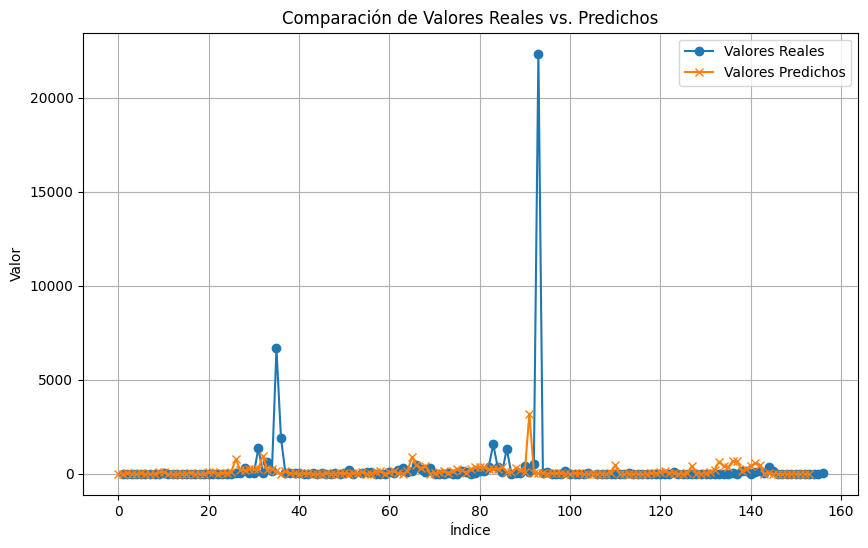

Error Absoluto Medio (MAE) test: 287.420025974026


In [66]:
import matplotlib.pyplot as plt
# Escalar los datos de prueba

# Predecir usando el mejor modelo encontrado
y_pred = knn_hpo.best_estimator_.predict(x_test)

# Graficar valores reales vs. predichos
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores Reales', marker='o')
plt.plot(y_pred, label='Valores Predichos', marker='x')
plt.title('Comparación de Valores Reales vs. Predichos')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)

# Mostrar el MAE
print(f"Error Absoluto Medio (MAE) test: {mae}")

In [50]:
from sklearn.tree import DecisionTreeRegressor

tree_pipe = Pipeline([
    ('tree', DecisionTreeRegressor(random_state=100472313))
])

#Árboles de regresión con HPO -----------------------------

param_grid = {
    'tree__criterion':['squared_error', 'friedman_mse', 'absolute_error'],
    'tree__max_depth': [5,7,9,11],
    'tree__min_samples_split': [40 ,50, 70, 90, 110, 130, 150],
}


tree_hpo = GridSearchCV(tree_pipe, param_grid, scoring='neg_mean_absolute_error', cv=inner_cv, n_jobs=-1, verbose=1)
tree_hpo.fit(x_train, y_train)


print(f"Mejor puntuación MAE: ", -tree_hpo.best_score_)
print("Mejores hiperparámetros:", tree_hpo.best_params_)


Fitting 7 folds for each of 84 candidates, totalling 588 fits
Mejor puntuación MAE:  215.69890476190477
Mejores hiperparámetros: {'tree__criterion': 'absolute_error', 'tree__max_depth': 11, 'tree__min_samples_split': 150}


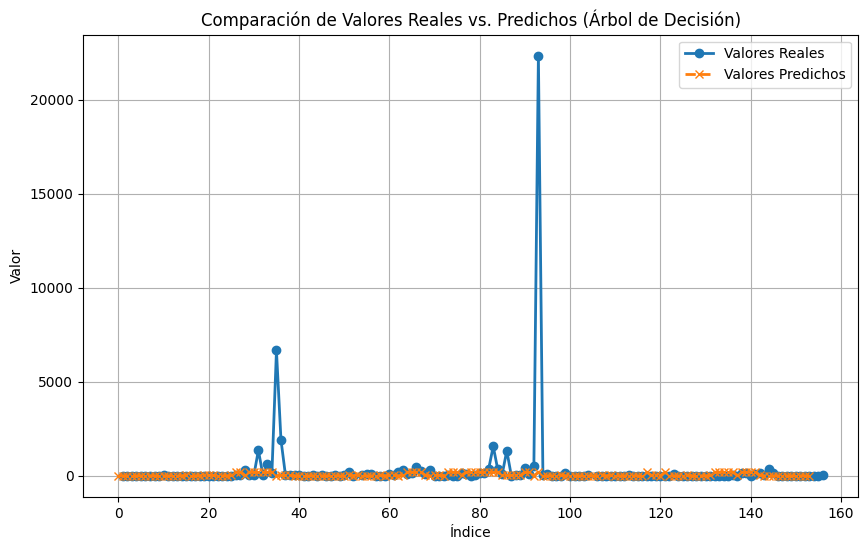

Error Absoluto Medio (MAE) test: 270.3807142857143


In [67]:
y_pred = tree_hpo.best_estimator_.predict(x_test)

# Graficar valores reales vs. predichos
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores Reales', marker='o', linestyle='-', linewidth=2)
plt.plot(y_pred, label='Valores Predichos', marker='x', linestyle='--', linewidth=2)
plt.title('Comparación de Valores Reales vs. Predichos (Árbol de Decisión)')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

mae = mean_absolute_error(y_test, y_pred)

# Mostrar el MAE
print(f"Error Absoluto Medio (MAE) test: {mae}")

In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
import time

# Define the Random Forest pipeline
rf_pipe = Pipeline([
    ('rf', RandomForestRegressor(random_state=100472313))
])

# Random Forest Regression with Hyperparameter Optimization (HPO)
param_grid = {
    'rf__n_estimators': [50, 100, 150, 200],  # Number of trees
    'rf__max_depth': [5, 10, 15, 20, None],  # Maximum depth of trees
    'rf__min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'rf__min_samples_leaf': [1, 2, 4],  # Minimum samples required at each leaf
    'rf__max_features': ['sqrt', 'log2']  # Number of features considered for splitting
}


rf_hpo = GridSearchCV(rf_pipe, param_grid, scoring='neg_mean_absolute_error', cv=inner_cv, n_jobs=-1, verbose=1)
rf_hpo.fit(x_train, y_train)


print(f"Best MAE score: {-rf_hpo.best_score_:.2f}")
print("Best hyperparameters:", rf_hpo.best_params_)


Fitting 7 folds for each of 360 candidates, totalling 2520 fits
Best MAE score: 293.76
Best hyperparameters: {'rf__max_depth': 15, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}


Random Forest - Error Absoluto Medio (MAE): 384.25


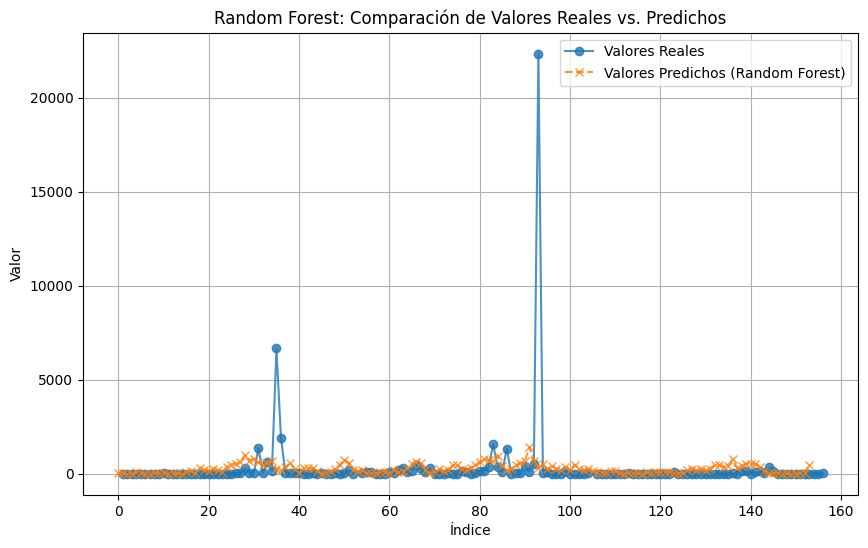

In [68]:
# Predict using the best model found during HPO
y_pred_rf = rf_hpo.best_estimator_.predict(x_test)

# Calculate MAE for Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Print the MAE
print(f"Random Forest - Error Absoluto Medio (MAE): {mae_rf:.2f}")

# Plot real vs predicted values for Random Forest
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores Reales', marker='o', linestyle='-', alpha=0.8)
plt.plot(y_pred_rf, label='Valores Predichos (Random Forest)', marker='x', linestyle='--', alpha=0.8)
plt.title('Random Forest: Comparación de Valores Reales vs. Predichos')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.svm import SVR

svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVR())
])

#SVM hpo -------------------

param_grid = {
    'svm__kernel': ['rbf', 'poly'],
    'svm__C': [1, 100, 1000, 1100],
    'svm__degree': [1, 2, 3],
    'svm__gamma': ['scale' , 0.001, 0.1]
}


svm_hpo = GridSearchCV(svm_pipe, param_grid, scoring='neg_mean_absolute_error', cv=inner_cv, n_jobs=-1, verbose=1)
svm_hpo.fit(x_train, y_train)


print(f"Mejor puntuación MAE: ", -svm_hpo.best_score_)
print("Mejores hiperparámetros:", svm_hpo.best_params_)

Average cross validation MAE is (omisión): 210.89 ± 214.48
Tiempo de ejecución: 0.1800 segundos.

Fitting 7 folds for each of 72 candidates, totalling 504 fits
Mejor puntuación MAE:  208.58530262709368
Mejores hiperparámetros: {'svm__C': 100, 'svm__degree': 1, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
Tiempo de ejecución: 1.9055 segundos.


SVM - Error Absoluto Medio (MAE): 272.83


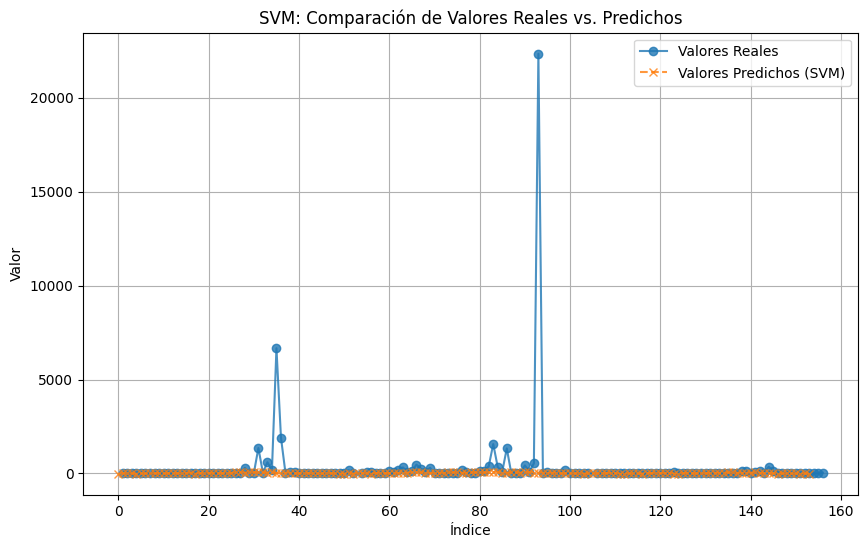

In [69]:
# Predict using the best model found during HPO
y_pred_svm = svm_hpo.best_estimator_.predict(x_test)

# Calculate MAE for SVM
mae_svm = mean_absolute_error(y_test, y_pred_svm)

# Print the MAE
print(f"SVM - Error Absoluto Medio (MAE): {mae_svm:.2f}")

# Plot real vs predicted values for SVM
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores Reales', marker='o', linestyle='-', alpha=0.8)
plt.plot(y_pred_svm, label='Valores Predichos (SVM)', marker='x', linestyle='--', alpha=0.8)
plt.title('SVM: Comparación de Valores Reales vs. Predichos')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()

In [58]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
import time

# Pipeline con MLPRegressor
mlp_pipe = Pipeline([
    ('mlp', MLPRegressor(random_state=100472313, max_iter=1000))
])

# Red neuronal con optimización de hiperparámetros -----------

param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50), (50, 25)],  # Tamaños de las capas ocultas
    'mlp__activation': ['relu', 'tanh'],  # Función de activación
    'mlp__solver': ['adam', 'sgd'],  # Algoritmo de optimización
    'mlp__alpha': [0.0001, 0.001, 0.01],  # Tasa de regularización
    'mlp__learning_rate': ['constant', 'adaptive']  # Estrategia de tasa de aprendizaje
}

mlp_hpo = GridSearchCV(mlp_pipe, param_grid, scoring='neg_mean_absolute_error', cv=inner_cv, n_jobs=-1, verbose=1)
mlp_hpo.fit(x_train, y_train)

print(f"Mejor puntuación MAE: {-mlp_hpo.best_score_:.2f}")
print("Mejores hiperparámetros:", mlp_hpo.best_params_)


Fitting 7 folds for each of 96 candidates, totalling 672 fits


C:\Users\Dongi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
54 fits failed out of a total of 672.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Dongi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Dongi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-pac

Mejor puntuación MAE: 217.23
Mejores hiperparámetros: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,), 'mlp__learning_rate': 'constant', 'mlp__solver': 'adam'}


C:\Users\Dongi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Regressor - Error Absoluto Medio (MAE): 295.15


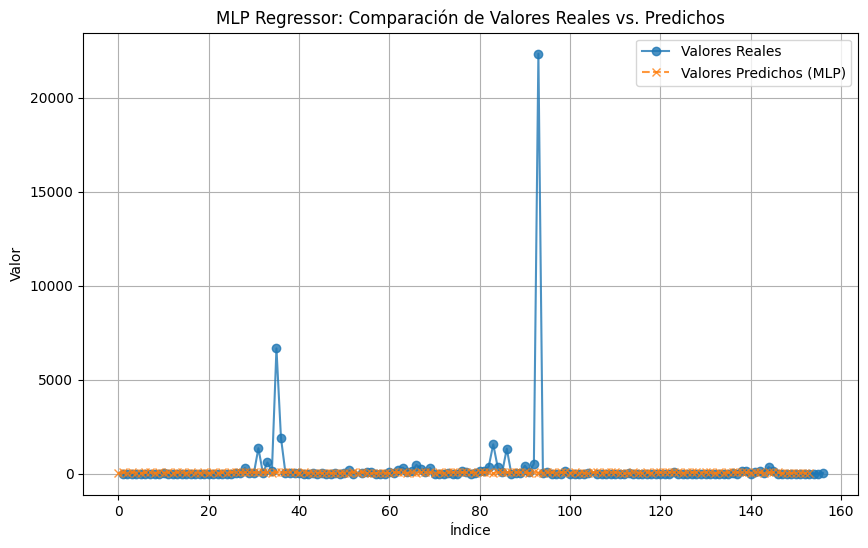

In [ ]:


y_pred_mlp = mlp_hpo.best_estimator_.predict(x_test)

# Calculate MAE for MLP
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)

# Print the MAE
print(f"MLP Regressor - Error Absoluto Medio (MAE): {mae_mlp:.2f}")

# Plot real vs predicted values for MLP
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores Reales', marker='o', linestyle='-', alpha=0.8)
plt.plot(y_pred_mlp, label='Valores Predichos (MLP)', marker='x', linestyle='--', alpha=0.8)
plt.title('MLP Regressor: Comparación de Valores Reales vs. Predichos')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Mejor puntuación MAE: 260.23
Mejores hiperparámetros: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.7}
MAE en el conjunto de test final: 340.04


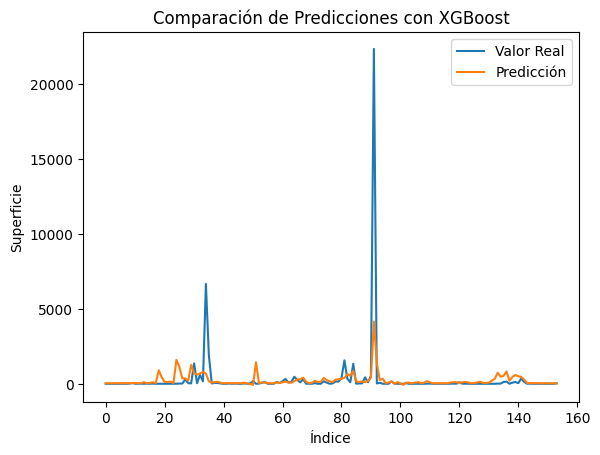

In [63]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import time
import matplotlib.pyplot as plt

xg_reg = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae')

# Definir el GridSearchCV para la búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}


grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(x_train, y_train)


print(f"Mejor puntuación MAE: {-grid_search.best_score_:.2f}")
print("Mejores hiperparámetros:", grid_search.best_params_)

# Usar el mejor modelo encontrado para hacer predicciones
best_model = grid_search.best_estimator_

# Hacer predicciones
y_pred = best_model.predict(x_test)

# Calcular el error medio absoluto (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE en el conjunto de test final: {mae:.2f}")

# Mostrar la comparación entre las predicciones y los valores reales
plt.plot(y_test.values, label="Valor Real")
plt.plot(y_pred, label="Predicción")
plt.legend()
plt.xlabel("Índice")
plt.ylabel("Superficie")
plt.title("Comparación de Predicciones con XGBoost")
plt.show()

Mean Absolute Error (MAE): 356.50


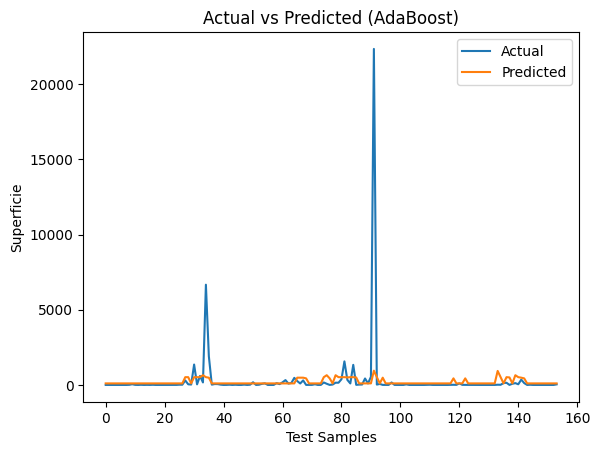

In [75]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


# Split data for validation (optional, if you want to check cross-validation)
# For simplicity, we will use the training set and test set defined above.
# Initialize the AdaBoost Regressor with default DecisionTreeRegressor as base model
ada_boost = AdaBoostRegressor(n_estimators=50, learning_rate=1.0)

# Train the AdaBoost model
ada_boost.fit(x_train, y_train)

# Predict on the test set
y_pred = ada_boost.predict(x_test)

# Evaluate the model using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae:.2f}')

# Plot actual vs predicted values
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.xlabel("Test Samples")
plt.ylabel("Superficie")
plt.title("Actual vs Predicted (AdaBoost)")
plt.show()

### Time series

In [ ]:
#TODO

### Con variables exogenas

In [ ]:
#TODO

## Performances

In [ ]:
#TODO

## Test Model


In [ ]:
#TODO